# <p style="text-align: center;"> <b> Data Modeling </b> </p>


---

# Table of Contents

---

# 1. Problem Statement <a class="anchor" id="1"></a>

## 1.1 Problem description <a class="anchor" id="1.1"></a>

Manga, a style of Japanese comic books and graphic novels, has achieved widespread popularity globally, contributing to a multibillion-dollar industry. The manga industry continues to grow rapidly, producing a diverse range of stories and genres.

In this context, the problem is to predict the rating score of a manga based on its features. The goal is to develop a model that can estimate the rating of a manga series, providing valuable insights for manga enthusiasts and publishers.

## 1.2 Purpose of solving the problem <a class="anchor" id="1.2"></a>

- **Enhanced Decision-Making**: By predicting the rating of a manga series, readers and enthusiasts can make more informed decisions about which manga to explore without having to read the entire series or spend time searching for reviews.

- **Market Insights**:  For publishers, distributors, and industry stakeholders, understanding the factors influencing a manga's rating provides valuable market insights. This knowledge can inform strategic decisions related to content creation, marketing, and audience targeting.

# 2. Data Preparation <a class="anchor" id="2"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast # for literal_eval
import warnings
warnings.filterwarnings('ignore')

In [2]:
manga_df = pd.read_csv('../data/processed_comic.csv')
manga_df.head(3)

,Title,Score,Vote,Ranked,Popularity,Members,Favorite,Volumes,Chapters,Status,Genres,Author,Recommended,Mixed Feelings,Not Recommended,Release date,Completed date
0,Berserk,9.47,331288,1,1,665300,122841,4,28,Publishing,"['Action', 'Adventure', 'Award Winning', 'Dram...","['Miura Kentarou', 'Studio Gaga']",233,15,10,1989-08-25,2023-12-13
1,JoJo no Kimyou na Bouken Part 7: Steel Ball Run,9.30,156368,2,26,256146,42864,24,96,Finished,"['Action', 'Adventure', 'Mystery', 'Supernatur...",['Araki Hirohiko'],120,7,1,2004-01-19,2011-04-19
2,Vagabond,9.24,136403,3,15,364891,40158,37,327,On Hiatus,"['Action', 'Adventure', 'Award Winning']","['Inoue Takehiko', 'Yoshikawa Eiji']",88,8,1,1998-09-03,2015-05-21


## 2.1 Feature Engineering<a class="anchor" id="2.1"></a>

### Feature Selection

1. We will select meaningful features that are suitable for the problem and drop unnecessary features.

    - The `Ranked` of manga series is determined based on `Score` by arranging the manga series in descending order of `Score`. Therefore, when predicting the `Score` of a manga, we cannot use `Ranked` as a feature, so we will drop this feature.
    
    - Two features, `Title` and `Author`, have a large number of unique values and do not provide meaningful insights for analyzing or predicting the score of a manga series. Therefore, we will drop these two features.

    - `Status` is a feature that indicates what status a manga is in (Publishing, Finished, ...). This feature has no meaning in predicting the `Score` of a manga, so we will drop this feature as well.


In [3]:
new_df = manga_df.drop(columns=['Title', 'Author','Ranked', 'Status'])

2. Use the correlation matrix to consider the correlation of features with `Score` and drop features with low correlation (correlation magnitude < 0.2)

But first, we will convert the numerical features to right data types. In this case, we will convert `Release date` and `Completed date`

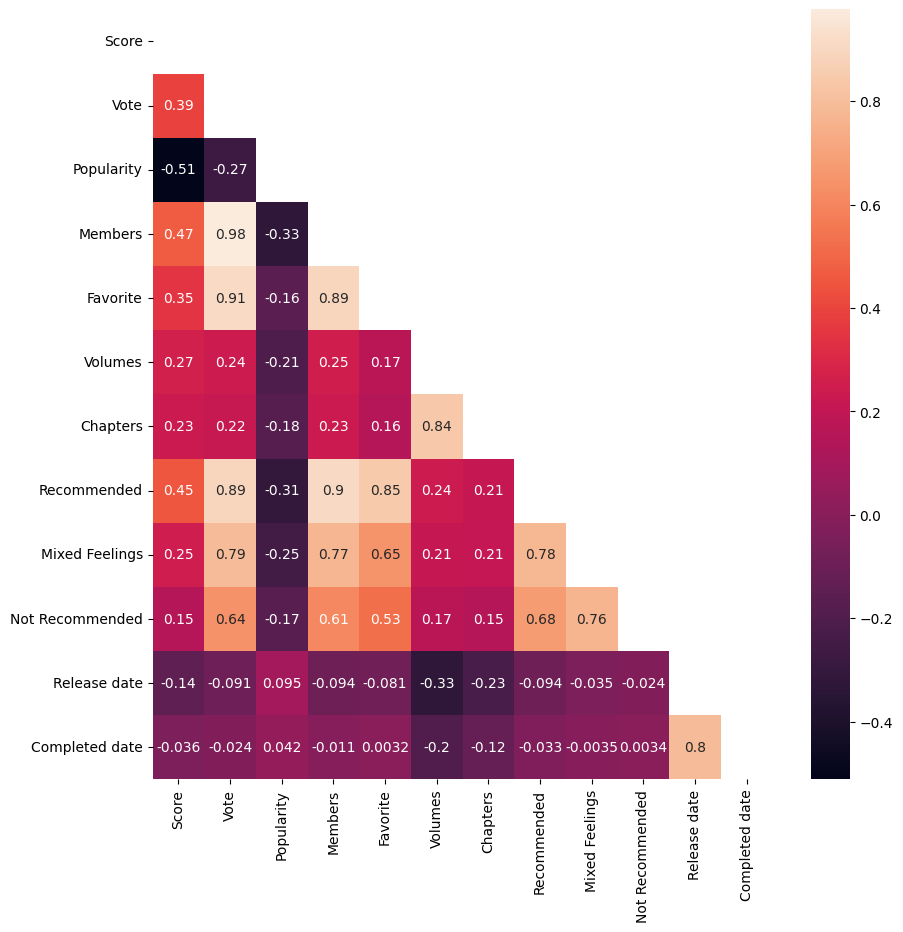

In [4]:
new_df[['Release date', 'Completed date']] = new_df[['Release date', 'Completed date']].apply(pd.to_datetime)

corr = new_df[['Score', 'Vote', 'Popularity', 'Members', 'Favorite','Volumes','Chapters','Recommended','Mixed Feelings','Not Recommended','Release date','Completed date']].corr()

fig, ax = plt.subplots(figsize=(10, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, ax=ax, mask=mask)
plt.show()

`Not Recommended`, `Released date` and `Completed date` have low correlation with `Score` and will be dropped.

In [5]:
new_df = new_df.drop(columns=['Release date', 'Completed date','Not Recommended'])

### Convert categorical features to numerical features

The `Genres` feature represents a multi-label category, so we need to convert it to a list type first and then use multi-label binarizer to convert it to a numerical feature.

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

# Convert 'Genres' into list of strings
new_df['Genres'] = new_df['Genres'].apply(ast.literal_eval)
mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb.fit_transform(new_df['Genres']), columns=mlb.classes_, index=new_df.index)
new_df = pd.concat([new_df, genres_encoded], axis=1).drop(columns=['Genres'])
new_df.head(3)

,Score,Vote,Popularity,Members,Favorite,Volumes,Chapters,Recommended,Mixed Feelings,Action,...,Girls Love,Gourmet,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense
0,9.47,331288,1,665300,122841,4,28,233,15,1,...,0,0,1,0,0,0,0,0,1,0
1,9.30,156368,26,256146,42864,24,96,120,7,1,...,0,0,0,1,0,0,0,0,1,0
2,9.24,136403,15,364891,40158,37,327,88,8,1,...,0,0,0,0,0,0,0,0,0,0


## 2.2 Split data <a class="anchor" id="2.2"></a>

In this step, we will follow these steps:

- Determine the target variable and the feature variables
- Split the data into training set, validation set and test set with the ratio of 80:10:10
- Scale the data using StandardScaler

In [7]:
from sklearn.model_selection import train_test_split, KFold, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,r2_score
from skopt import BayesSearchCV
from sklearn.preprocessing import MinMaxScaler


features = ['Vote',  'Popularity', 'Members', 'Favorite', 'Volumes', 'Chapters',
            'Recommended', 'Mixed Feelings'] + list(mlb.classes_)
target = 'Score'

train_data, test_data = train_test_split(new_df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

X_train, y_train = train_data[features], train_data[target]
X_val, y_val = val_data[features], val_data[target]
X_test, y_test = test_data[features], test_data[target]

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


# 3. Create, train and test models <a class="anchor" id="3"></a>

## Models

To solve the problem, we will use the following machine learning models:

- Linear Regression
- XGBoost
- Random Forest

In [8]:
models = {
    'Linear Regression': LinearRegression(),
    'XGBoost': XGBRegressor(n_jobs=-1),
    'Random Forest': RandomForestRegressor(n_jobs=-1)
}

## Metrics for evaluation models

The problem of predicting the `Score` of a manga series is a regression problem, so we will use metrics suitable for the regression problem to evaluate the model. Metrics used include:

- Mean Squared Error (MSE)
- R2 Score

## Train models on training data

In [9]:
train_scores = {}
val_scores = {}
mse_train = {}
mse_val = {}
# Dùng vòng lặp để huấn luyện và vẽ learning curve cho từng mô hình
for model_name, model in models.items():
    model.fit(X_train, y_train)
    train_scores[model_name] = model.score(X_train, y_train)
    val_scores[model_name] = model.score(X_val, y_val)
    mse_train[model_name] = mean_squared_error(y_train, model.predict(X_train))
    mse_val[model_name] = mean_squared_error(y_val, model.predict(X_val))

**Visualize the results of the models**

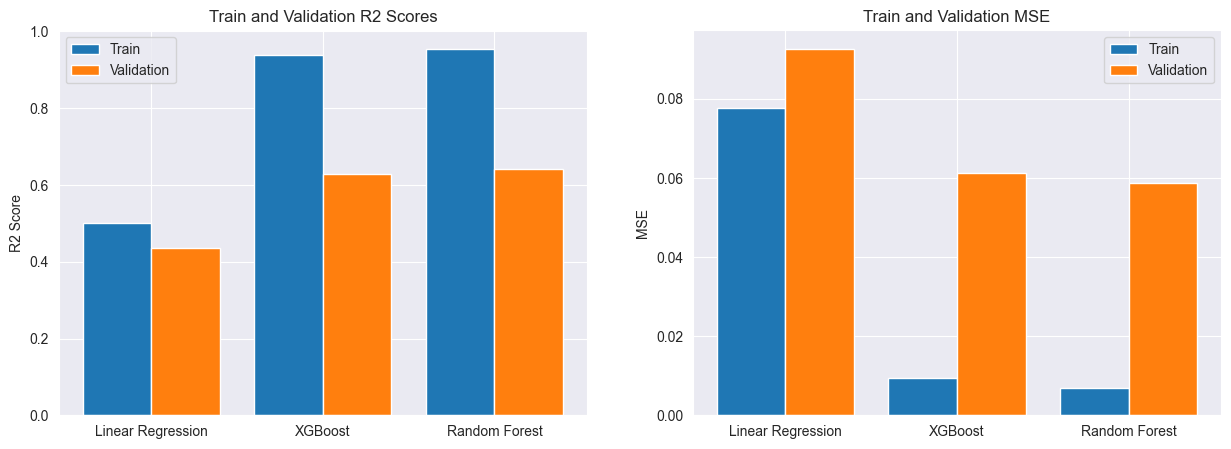

In [10]:
categories = list(train_scores.keys())
train_values = list(train_scores.values())
val_values = list(val_scores.values())
mse_train_values = list(mse_train.values())
mse_val_values = list(mse_val.values())

indices = np.arange(len(categories))
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Biểu đồ cột đôi cho train scores
ax[0].bar(indices - 0.2, train_values, width=0.4, label='Train')
ax[0].bar(indices + 0.2, val_values, width=0.4, label='Validation')
ax[0].set_ylabel('R2 Score')
ax[0].set_xticks(indices)
ax[0].set_xticklabels(categories)
ax[0].set_title('Train and Validation R2 Scores')
ax[0].legend()

# Biểu đồ cột đôi cho MSE train
ax[1].bar(indices - 0.2, mse_train_values, width=0.4, label='Train')
ax[1].bar(indices + 0.2, mse_val_values, width=0.4, label='Validation')
ax[1].set_xticks(indices)
ax[1].set_ylabel('MSE')
ax[1].set_xticklabels(categories)
ax[1].set_title('Train and Validation MSE')
ax[1].legend()

plt.show()

**Learning process of models**

The three machine learning algorithms used in this study learn once on the entire dataset. Unlike deep learning algorithms, which learn gradually over each epoch, it is difficult to visualize the learning process of these models.

We will address this challenge by using the learning curve of the scikit-learn library. This will allow us to visualize the learning process of these models by having them learn gradually over multiple training runs with increasing training set sizes

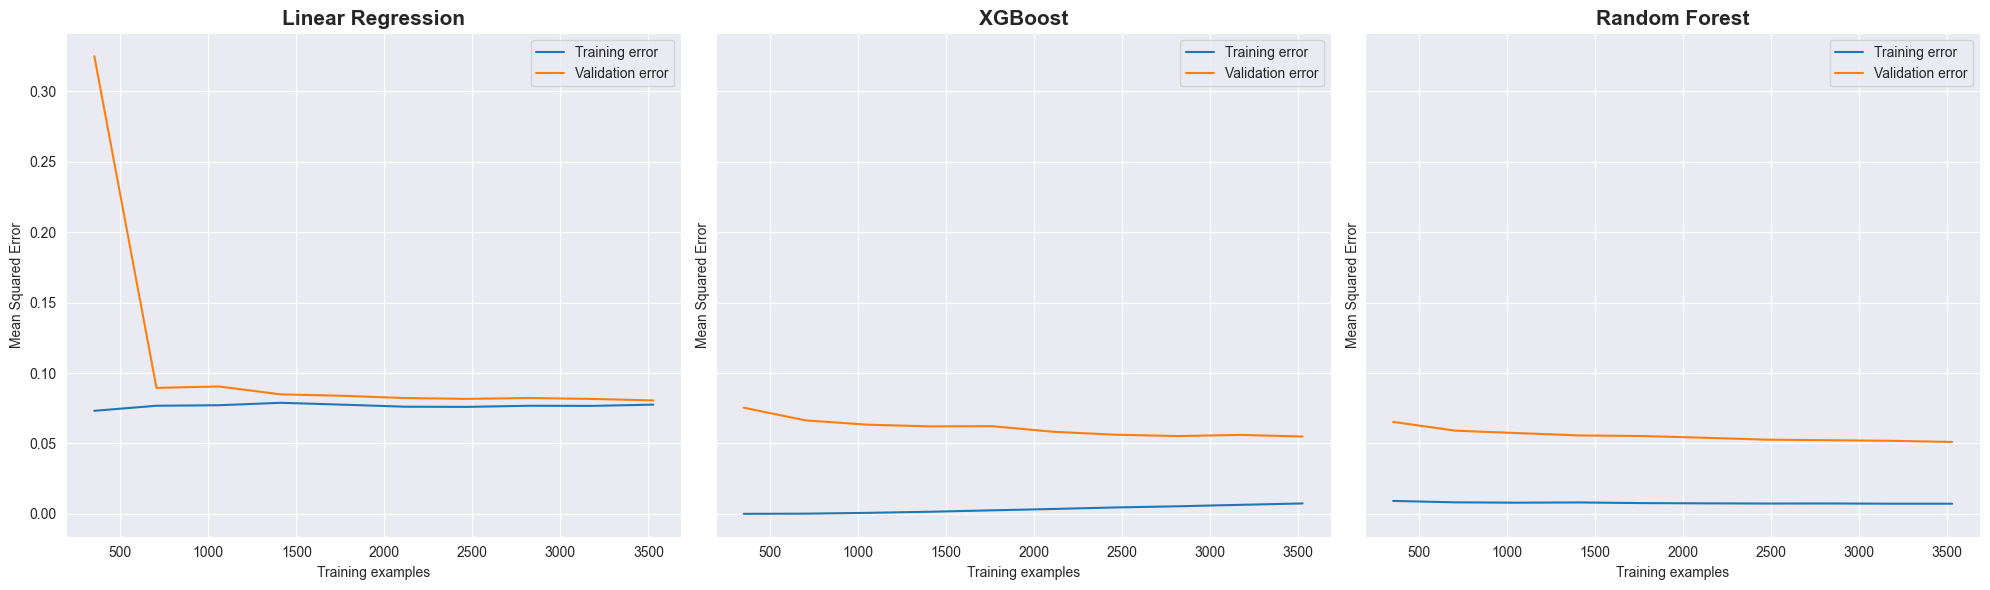

In [11]:
def plot_learning_curve(model, X, y, ax, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    val_scores_mean = -np.mean(val_scores, axis=1)

    ax.plot(train_sizes, train_scores_mean, label='Training error')
    ax.plot(train_sizes, val_scores_mean, label='Validation error')

    ax.set_title(title, fontsize=15,fontweight='bold')
    ax.set_xlabel('Training examples')
    ax.set_ylabel('Mean Squared Error')
    ax.legend()
    ax.grid(True)

# Create subplots in a single row
fig, axes = plt.subplots(1, 3, figsize=(20, 6),sharey=True)

# Plot learning curves for each model
for (model_name, model), ax in zip(models.items(), axes):
    plot_learning_curve(model, X_train, y_train, ax, model_name)

plt.tight_layout()
plt.show()

## Fine-tune models on validation data

In [12]:
param_lr = {
    'fit_intercept': [True, False],
    'positive': [True, False],
    'n_jobs': [-1, 1],
}
param_xgb = {
    'n_estimators': (10, 100),
    'max_depth': (1, 10),
    'learning_rate': (0.01, 1.0, 'log-uniform'),
}
params_rf = {
    'n_estimators': (10, 100),
    'max_depth': (1, 10),
    'max_features': (0.1, 1.0, 'uniform'),
}

np.int = int
opt_lr = BayesSearchCV(
    LinearRegression(),
    param_lr,
    n_iter=32,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='r2',
    random_state=42,
    n_jobs=-1
)
opt_xgb = BayesSearchCV(
    XGBRegressor(n_jobs=-1),
    param_xgb,
    n_iter=32,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

opt_rf = BayesSearchCV(
    RandomForestRegressor(n_jobs=-1),
    params_rf,
    n_iter=32,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

opt_models = {
    'Linear Regression': opt_lr,
    'XGBoost': opt_xgb,
    'Random Forest': opt_rf
}

opt_lr.fit(X_val, y_val)
opt_xgb.fit(X_val, y_val)
opt_rf.fit(X_val, y_val)

for model_name, model in opt_models.items():
    print(f'{model_name}: {model.best_score_:.4f}')
    for param, value in model.best_params_.items():
        print(f'{param}: {value}')
    print()

Linear Regression: 0.1634
fit_intercept: True
n_jobs: -1
positive: True

XGBoost: 0.5763
learning_rate: 0.2648538175156562
max_depth: 1
n_estimators: 85

Random Forest: 0.5651
max_depth: 5
max_features: 0.8442493738890466
n_estimators: 36



## Retrain models on training and validation data

In [13]:
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

opt_lr.best_estimator_.fit(X_train_val, y_train_val)
opt_xgb.best_estimator_.fit(X_train_val, y_train_val)
opt_rf.best_estimator_.fit(X_train_val, y_train_val)  

## Evaluate models on test data

We still use both metrics to evaluate the models on the test set

In [ ]:
test_scores = {}
mse_test = {}
for model_name, model in opt_models.items():
    test_scores[model_name] = model.best_estimator_.score(X_test, y_test)
    mse_test[model_name] = mean_squared_error(y_test, model.predict(X_test))

**Visualize the results of the models**

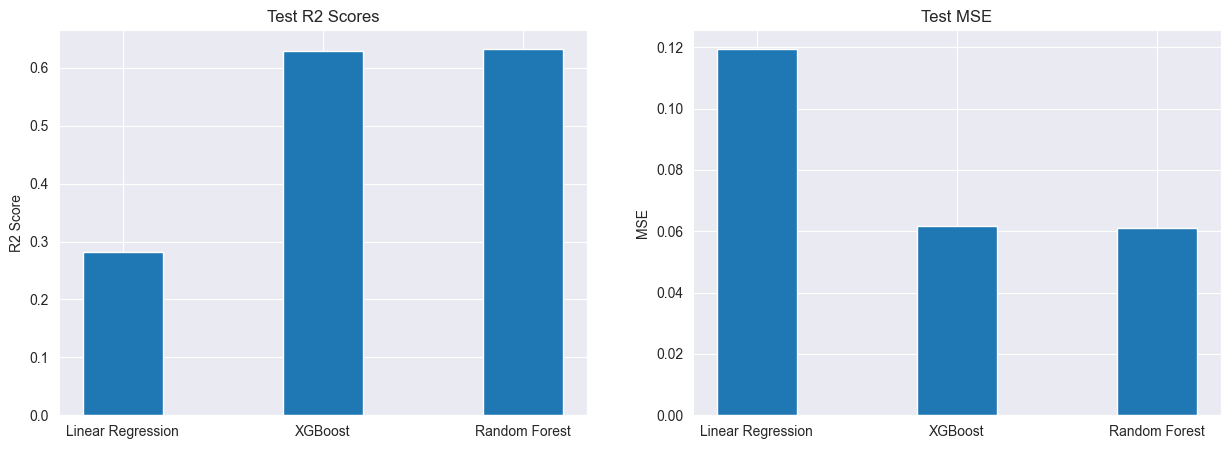

In [14]:
categories = list(test_scores.keys())
test_values = list(test_scores.values())
mse_test_values = list(mse_test.values())

indices = np.arange(len(categories))
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Biểu đồ cột đôi cho test scores
ax[0].bar(indices, test_values, width=0.4)
ax[0].set_ylabel('R2 Score')
ax[0].set_xticks(indices)
ax[0].set_xticklabels(categories)
ax[0].set_title('Test R2 Scores')

# Biểu đồ cột đôi cho MSE test
ax[1].bar(indices, mse_test_values, width=0.4)
ax[1].set_xticks(indices)
ax[1].set_ylabel('MSE')
ax[1].set_xticklabels(categories)
ax[1].set_title('Test MSE')

plt.show()

Let's see 10 random samples from the test set and compare the actual `Score` with the predicted `Score` of the models

In [18]:
df = pd.DataFrame({
    'Actual': y_test,
    'Linear Regression': opt_lr.best_estimator_.predict(X_test),
    'XGBoost': opt_xgb.best_estimator_.predict(X_test),
    'Random Forest': opt_rf.best_estimator_.predict(X_test)
})
df.sample(10)

,Actual,Linear Regression,XGBoost,Random Forest
3404,7.27,7.458768,7.118206,7.076072
1728,7.57,7.396776,7.266372,7.253488
1738,7.56,7.602819,7.931497,7.989500
3682,7.22,7.358669,7.214533,7.211258
6027,6.92,7.332972,7.098305,7.074610
4676,7.09,7.394935,7.164703,7.237591
701,7.91,7.275116,7.492319,7.547125
6064,6.91,7.243149,7.021623,7.102002
3352,7.27,7.322984,7.205010,7.254637
4677,7.09,7.396448,7.257975,7.310663
